In [ ]:
!pip install torch torchvision torchaudio
!pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-p3jv59qu
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-p3jv59qu
  Resolved https://github.com/facebookresearch/detectron2.git to commit a9c0821a12ad353fb2a96f019515990d5460c5ac
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.5/83.5 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 40.5 MB/s eta 0:00:00
  Created wheel for detectron2: filename=detectron2-0.6-cp312-cp312-linux_x86_64.whl size=6352520 sha256=16a7d6d6558fe0745f96c68110f0bd0ee7aac0ca8b6534cbc20fb7a7f21328be
  Stored in directory: /tmp/pip-ephem-wheel-cache-1xfn6o4v/wheels/d3/6e/bd/1969578f1456a6be

In [ ]:
import torch, cv2, numpy as np, pandas as pd
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog
from google.colab.patches import cv2_imshow


In [ ]:
import torch
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
else:
    print("Running on CPU mode.") #checking gpu or cpu


CUDA available: True
GPU: Tesla T4


In [ ]:
!nvidia-smi
!pip install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install -U 'git+https://github.com/facebookresearch/detectron2.git'


Wed Nov  5 06:34:39 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   51C    P8             10W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
MODEL_PATH = "/content/drive/MyDrive/Uni_Research/bubble_model_output/model_final.pth"


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!ls -lh "/content/drive/MyDrive/bubble_model_output/" #confirming file existance on teh location


Mounted at /content/drive
total 335M
-rw------- 1 root root  90K Oct 18 04:50 events.out.tfevents.1760762471.5117bab7bc4f.705.0
drwx------ 2 root root 4.0K Oct 18 04:42 inference
-rw------- 1 root root   15 Oct 18 04:50 last_checkpoint
-rw------- 1 root root  60K Oct 18 04:50 metrics.json
-rw------- 1 root root 335M Oct 18 04:50 model_final.pth


In [ ]:
import os
MODEL_PATH = "/content/drive/MyDrive/bubble_model_output/model_final.pth"
print("Exists:", os.path.exists(MODEL_PATH))


Exists: True


In [ ]:
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2
cfg.MODEL.WEIGHTS = MODEL_PATH
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.MODEL.DEVICE = "cuda"

predictor = DefaultPredictor(cfg)
print("Model loaded successfully from:", MODEL_PATH)


Model loaded successfully from: /content/drive/MyDrive/bubble_model_output/model_final.pth


In [ ]:
IMG_PATH = "/content/drive/MyDrive/bubble_model_output/test1.png"


Image loaded: /content/drive/MyDrive/bubble_model_output/test1.png


/usr/local/lib/python3.12/dist-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4322.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Detected 3 bubbles
   id  left  right  top  bottom  score  slug_length_px
0   2    38    192  318     376    1.0            85.0
1   3   277    433  315     374    1.0            83.0
2   1   516    671  314     371    1.0             NaN


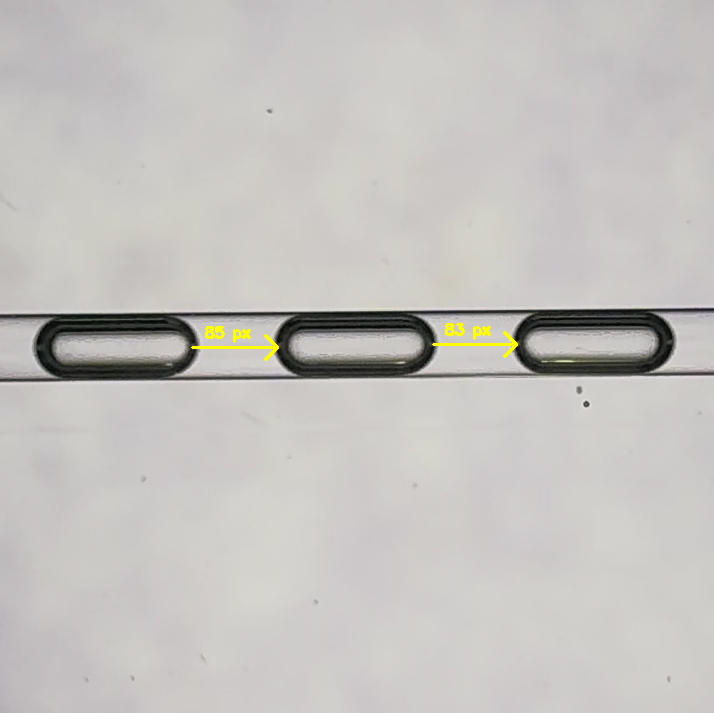

💾 Saved results to slug_lengths_test1.csv


In [ ]:
import cv2, numpy as np, pandas as pd
from google.colab.patches import cv2_imshow

#loading image
IMG_PATH = "/content/drive/MyDrive/bubble_model_output/test1.png"
img = cv2.imread(IMG_PATH)

if img is None:
    print("Image not found! Check path.")
else:
    print("Image loaded:", IMG_PATH)

#run inference
outputs = predictor(img)
instances = outputs["instances"].to("cpu")

masks = instances.pred_masks.numpy()
boxes = instances.pred_boxes.tensor.numpy()
scores = instances.scores.numpy()

print(f"Detected {len(masks)} bubbles")

bubbles = []
for i, m in enumerate(masks):
    ys, xs = np.where(m)
    if len(xs) == 0:
        continue
    left, right = int(xs.min()), int(xs.max())
    top, bottom = int(ys.min()), int(ys.max())
    bubbles.append({
        "id": i+1,
        "left": left,
        "right": right,
        "top": top,
        "bottom": bottom,
        "score": round(float(scores[i]), 2)
    })

bubbles = sorted(bubbles, key=lambda x: x["left"]) #tracking bubbles moving from left to right.


for i in range(len(bubbles)-1):
    slug = bubbles[i+1]["left"] - bubbles[i]["right"]   #calculating slug length between edges
    bubbles[i]["slug_length_px"] = slug
bubbles[-1]["slug_length_px"] = None

df = pd.DataFrame(bubbles)
print(df) #save + show result


draw = img.copy()
for i in range(len(bubbles)-1):
    b1, b2 = bubbles[i], bubbles[i+1]
    x1, x2 = b1["right"], b2["left"]
    y = int((b1["top"] + b1["bottom"]) / 2)
    cv2.arrowedLine(draw, (x1, y), (x2, y), (0, 255, 255), 2, tipLength=0.2)
    midx = int((x1 + x2) / 2)
    cv2.putText(draw, f"{b1['slug_length_px']} px", (midx - 30, y - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,255), 2)
cv2_imshow(draw)

df.to_csv("/content/slug_lengths_test1.csv", index=False)
print("Saved results to slug_lengths_test1.csv")


### Testing with Gradio web app interface for easy analysis

In [ ]:
!pip install gradio
import gradio as gr
import cv2, numpy as np, pandas as pd


In [ ]:
def analyze(img):
    if isinstance(img, np.ndarray):
        image_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    else:
        image_bgr = cv2.imread(img)

    outputs = predictor(image_bgr)
    instances = outputs["instances"].to("cpu")
    masks = instances.pred_masks.numpy()
    boxes = instances.pred_boxes.tensor.numpy()
    scores = instances.scores.numpy()

    bubbles = []
    for i, m in enumerate(masks):
        ys, xs = np.where(m)
        if len(xs) == 0: continue
        left, right = int(xs.min()), int(xs.max())
        top, bottom = int(ys.min()), int(ys.max())
        bubbles.append({
            "id": i+1,
            "left": left,
            "right": right,
            "top": top,
            "bottom": bottom,
            "score": round(float(scores[i]), 2)
        })

    bubbles = sorted(bubbles, key=lambda x: x["left"])
    for i in range(len(bubbles)-1):
        bubbles[i]["slug_length_px"] = bubbles[i+1]["left"] - bubbles[i]["right"]
    if bubbles: bubbles[-1]["slug_length_px"] = None

    # draw quick overlay
    draw = image_bgr.copy()
    for i in range(len(bubbles)-1):
        b1, b2 = bubbles[i], bubbles[i+1]
        x1, x2 = b1["right"], b2["left"]
        y = int((b1["top"] + b1["bottom"]) / 2)
        cv2.arrowedLine(draw, (x1,y), (x2,y), (0,255,255), 2, tipLength=0.2)
        midx = int((x1+x2)/2)
        cv2.putText(draw, f"{b1['slug_length_px']} px", (midx-20, y-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,255), 2)
    draw_rgb = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    df = pd.DataFrame(bubbles)
    return draw_rgb, df


In [ ]:
demo = gr.Interface(
    fn=analyze,
    inputs=gr.Image(type="numpy", label="Upload bubble image"),
    outputs=[
        gr.Image(type="numpy", label="Annotated output"),
        gr.Dataframe(label="Slug length table (px)")
    ],
    title="Taylor Bubble Analyzer",
    description="Upload an image of Taylor flow to measure bubble slug length automatically."
)

demo.launch(debug=True)


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://f40b8354860829d978.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/gradio/queueing.py", line 759, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/gradio/route_utils.py", line 354, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/gradio/blocks.py", line 2116, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/gradio/blocks.py", line 1623, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ignore
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/anyio/to_thread.py", line 56, in run_sync
    return await get_async_backend().run_sync_in_worker_thread(
           ^^^^^

Created dataset file at: .gradio/flagged/dataset1.csv
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://f40b8354860829d978.gradio.live
